In [33]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
import cmocean
from pyqg_generative.tools.plot_helpers import *
from pyqg_generative.tools.comparison_tools import dataset_smart_read
from pyqg_generative.tools.operators import ave_lev
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev
from pyqg_generative.tools.parameters import EDDY_PARAMS
from pyqg_generative.tools.spectral_tools import spectrum
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# First impression of the configuration

In [2]:
ds = {}
for res in ['48', '64', '96', '256']:
    ds[res] = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_{res}/[0-9].nc', delta=0.25)    

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc


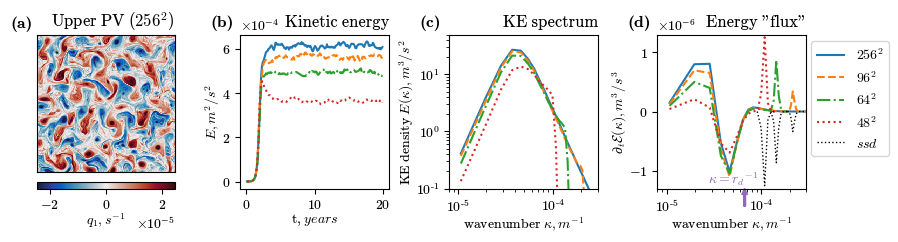

In [186]:
default_rcParams({})
matplotlib.rcParams.update({'figure.subplot.wspace': 0.4})
ls = {'256': '-', '96': '--', '64': '-.', '48': ':'}

plt.subplot(1,4,1)
q = ds['256'].q.isel(time=-1,run=0,lev=0)
imshow(q, cbar_label='$q_1, s^{-1}$', location='bottom')
plt.title('Upper PV ($256^2$)')

plt.subplot(1,4,2)
for res in ['256', '96', '64', '48']:
    ds[res].KE_time.plot(ls=ls[res])
plt.ylabel(r'$E, m^2/s^2$')
plt.xlabel('t, $years$')
plt.title('Kinetic energy')

plt.subplot(1,4,3)
for res in ['256', '96', '64', '48']:
    ds[res].KEspecr_mean.plot(ls=ls[res])
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-1, 5e+1])
plt.xlim([8e-6,3e-4])
plt.ylabel('KE density $E(\kappa), m^3/s^2$')
plt.xlabel(r'wavenumber $\kappa, m^{-1}$')
plt.title('KE spectrum')

plt.subplot(1,4,4)
for res in ['256', '96', '64', '48']:
    ds[res].Efluxr.plot(ls=ls[res], label=f'${res}^2$')
flag = True
for res in ['256', '96', '64', '48']:
    idx = 0
    for i in range(len(ds[res].kr)):
        if ds[res].Dissspecr[i] < 0:
            idx = i-1
            break
    ds[res].Dissspecr[idx:].plot(color='k', ls=':', lw=1, label='$ssd$' if flag else None); flag=False
plt.xscale('log')
plt.xlim([8e-6,3e-4])
plt.ylim([-1.3e-6, 1.3e-6])
plt.ylabel(r'$\partial_t \mathcal{E}(\kappa), m^3/s^3$')
plt.xlabel(r'wavenumber $\kappa, m^{-1}$')
plt.title('Energy "flux"')
plt.legend(ncol=1, bbox_to_anchor=(1.6,1), loc='upper right')
plt.arrow(1/15000, -1.6e-6, 0, +0.2e-6, width=3e-6, head_length=1e-7, clip_on=False, color='tab:purple')
plt.text(5e-5, -1.2e-6, '$\kappa={r_d}^{-1}$', color='tab:purple', horizontalalignment='center')

set_letters()
plt.savefig('paper_figures_1/fig1.pdf')

# Subgrid forcing snapshots

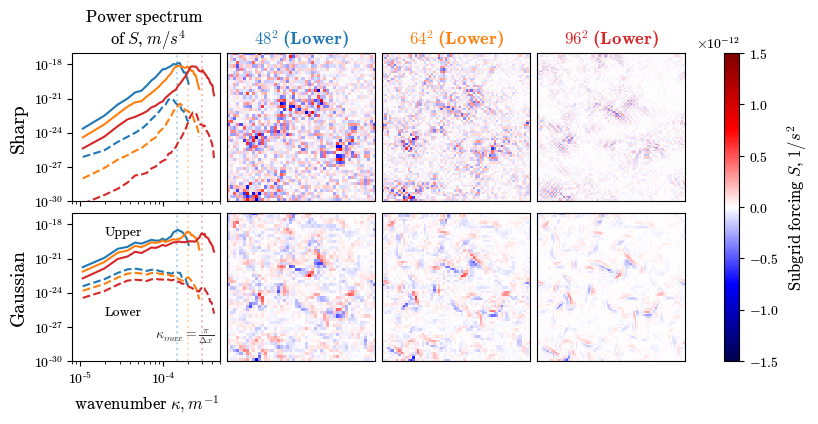

In [295]:
from cycler import cycler
default_rcParams({
    'axes.titlelocation' : 'center', 
    'axes.labelsize': 12,
    'axes.labelpad': 4,
    'axes.prop_cycle': cycler(color=['tab:blue', 'tab:orange', 'tab:red'])
    })
q = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/0.nc').q.isel(time=-1)
lev=1
if lev==1:
    ylim = [1e-30, 1e-20]
    vmax=1.5e-12
else:
    ylim = [1e-27, 1e-17]
    vmax=5e-11
    
fig, axs = plt.subplots(2,4,figsize=(10,4))
plt.subplots_adjust(hspace=0.08, wspace=0)
for j, (resolution, res_name) in enumerate(zip([48, 64, 96], ['$48^2$', '$64^2$', '$96^2$'])):
    for i, operator in enumerate([Operator1, Operator2]):   
        forcing = xr.DataArray(PV_subgrid_forcing(q.values, resolution, operator, EDDY_PARAMS)[0], dims=('lev', 'y', 'x'))
        
        sp = spectrum(time=slice(None,None))(forcing.expand_dims('time'))
        line = axs[i][0].loglog(sp.k, sp.isel(lev=0).values, label=res_name)
        axs[i][0].loglog(sp.k, sp.isel(lev=1).values, color=line[0].get_color(), ls='--')
        axs[i][0].set_box_aspect(1)
        axs[i][0].set_ylim([1e-30,1e-17])
        axs[i][0].set_xlim([8e-6, 5e-4])
        dx = 1e+6 / resolution
        axs[i][0].axvline(x=np.pi / dx, color=line[0].get_color(), ls=':', alpha=0.3)
        
        ax = axs[i][j+1]
        im = imshow(forcing.isel(lev=lev), vmax=vmax, ax=ax, cbar=False, cmap='seismic')
        if i==0:
            ax.set_title(res_name+' (Lower)', color=line[0].get_color(), fontweight='bold')

#        if i==1:
#            axs[i][0].legend(ncol=1, fontsize=8)
axs[1][0].text(2e-5, 1e-26, 'Lower')
axs[1][0].text(2e-5, 1e-19, 'Upper')
axs[1][0].text(8e-5, 1e-28, r'$\kappa_{max}=\frac{\pi}{\Delta x}$', alpha=0.8)
cbar = plt.colorbar(im, ax=axs, label='Subgrid forcing $S$, $1/s^2$')
axs[1][0].set_xlabel(r'wavenumber $\kappa, m^{-1}$')
axs[0][0].set_title('Power spectrum \n of $S$, $m/s^4$')
axs[0][0].set_ylabel('Sharp', fontsize=14)
axs[1][0].set_ylabel('Gaussian', fontsize=14)
axs[0][0].set_xticklabels([])
fig.align_ylabels()
plt.savefig('paper_figures_1/subgrid_forcing.pdf', bbox_inches='tight', pad_inches=0)

# Snapshots of models

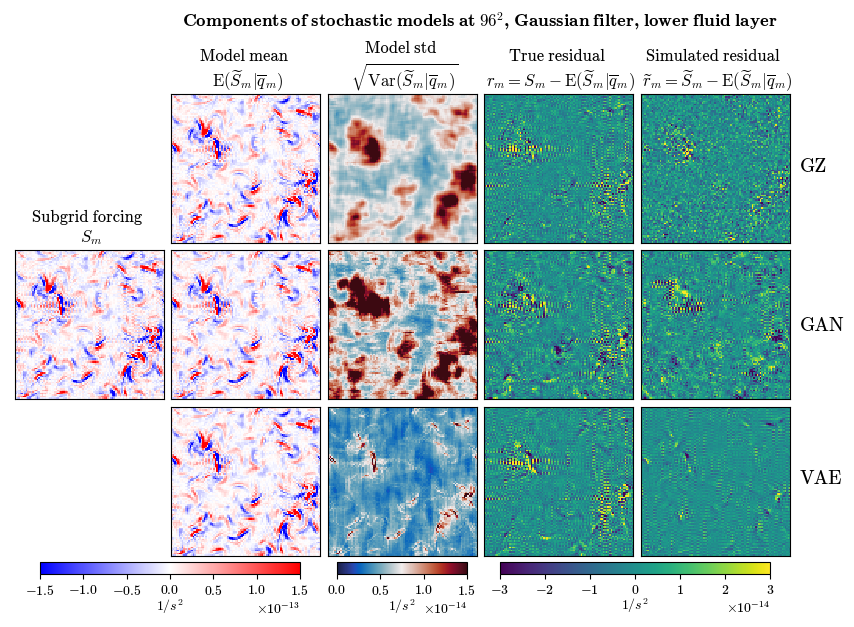

In [73]:
default_rcParams({'axes.titlelocation' : 'center'})
prms = {'v_total': 1.5e-13, 'v_std': 1.5e-14, 'v_residual': 3e-14, 'resolution': 96, 'Operator': 'Operator2', 'lev': 1, 'run': 10, 'time': -1}

fig, axs = plt.subplots(3,5,figsize=(10,6))
plt.subplots_adjust(hspace=0.05, wspace=0.05)
gz = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+prms['Operator']+'-'+str(prms['resolution'])+'/MeanVarModel-3/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])
gan = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+prms['Operator']+'-'+str(prms['resolution'])+'/CGANRegression-1/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])
vae = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+prms['Operator']+'-'+str(prms['resolution'])+'/CVAERegression-None-4/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])

for row, model in enumerate([gz, gan, vae]):
    if row ==1:
        imshow(model.q_forcing_advection, ax = axs[row][0], cmap='bwr', cbar=False, vmax=prms['v_total'])
    else:
        axs[row][0].remove()
    im_mean = imshow(model.q_forcing_advection_mean, ax = axs[row][1], cmap='bwr', cbar=False, vmax=prms['v_total'])
    im_std = imshow(model.q_forcing_advection_std, ax = axs[row][2], cmap=cmocean.cm.balance, cbar=False, vmax=prms['v_std'])
    im_res = imshow(model.q_forcing_advection_res, ax = axs[row][3], cmap='viridis', cbar=False, vmax=prms['v_residual'])
    imshow(model.q_forcing_advection_gen_res, ax = axs[row][4], cmap='viridis', cbar=False, vmax=prms['v_residual'])

axs[1][0].set_title('Subgrid forcing \n $S_m$')
axs[0][1].set_title('Model mean \n $\mathrm{E}(\widetilde{S}_m|\overline{q}_m)$')
axs[0][2].set_title('Model std \n $\sqrt{\mathrm{Var}(\widetilde{S}_m|\overline{q}_m)}$')
axs[0][3].set_title('True residual \n $r_m = S_m-\mathrm{E}(\widetilde{S}_m|\overline{q}_m)$')
axs[0][4].set_title('Simulated residual \n $\widetilde{r}_m = \widetilde{S}_m - \mathrm{E}(\widetilde{S}_m|\overline{q}_m)$')

plt.colorbar(im_mean, cax=fig.add_axes([0.15,0.08,0.26,0.02]), orientation='horizontal', label='$1/s^2$')
plt.colorbar(im_std, cax=fig.add_axes([0.447,0.08,0.13,0.02]), orientation='horizontal', label='$1/s^2$')
plt.colorbar(im_res, cax=fig.add_axes([0.61,0.08,0.27,0.02]), orientation='horizontal', label='$1/s^2$')
fig.text(0.91,0.75,'GZ', fontsize=14)
fig.text(0.91,0.485,'GAN', fontsize=14)
fig.text(0.91,0.23,'VAE', fontsize=14)

fig.suptitle('Components of stochastic models at $96^2$, Gaussian filter, lower fluid layer', y=1.02, x=0.59, fontweight='bold')

plt.savefig(f'paper_figures_1/subgrid_models_snapshot.pdf')

# Schematic illustration of GZ and GAN/VAE

In [247]:
prms = {'v_total': 1.5e-13, 'v_std': 1.5e-14, 'v_residual': 3e-14, 'resolution': 96, 'Operator': 'Operator2', 'lev': 1, 'run': 10, 'time': -1}
gz = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+prms['Operator']+'-'+str(prms['resolution'])+'/MeanVarModel-3/offline_test.nc').isel(run=prms['run'],time=prms['time'])
gan = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+prms['Operator']+'-'+str(prms['resolution'])+'/CGANRegression-1/offline_test.nc').isel(run=prms['run'],time=prms['time'])

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/'+prms['Operator']+'-'+str(prms['resolution'])+'/*.nc', combine='nested', concat_dim='run')
test = ds.isel(run=slice(275,300)).isel(run=prms['run'],time=prms['time'])

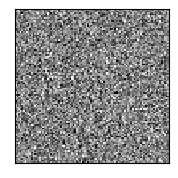

In [286]:
default_rcParams({'axes.titlelocation' : 'center'})

for row in [0,1]:
    for column, (var, cmap, title) in enumerate(
            zip(
            [test.q, test.q_forcing_advection, gz.q_forcing_advection_mean, gz.q_forcing_advection_std, np.random.randn(2,96,96)], 
            [None, 'seismic', 'seismic', cmocean.cm.balance, 'gray'],
            ['q', 'forcing', 'Model mean', 'Model std', 'White noise']
            )
        ):
        imshow(var[row], cbar=False, cmap=cmap)
        plt.savefig(f'paper_figures_1/schematic_lev_{row}_{title}.pdf', bbox_inches='tight', pad_inches=0, transparent=True)

# Rescaled plotter

Text(0.59, 1.02, 'Prediction of stochastic models at $96^2$, Gaussian filter, lower fluid layer')

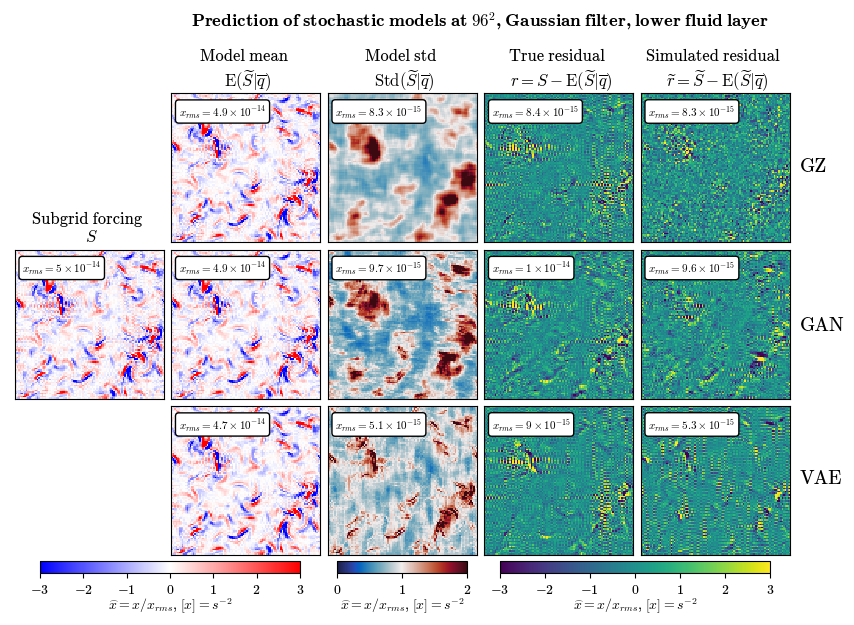

In [130]:
from pyqg_generative.tools.operators import gcm_filter
default_rcParams({'axes.titlelocation' : 'center'})
prms = {'v_total': 3, 'v_std': 2, 'v_residual': 3, 'resolution': 96, 'Operator': 'Operator2', 'lev': 1, 'run': 10, 'time': -1}

cbar_prms = {'normalize': True, 'cbar': False}

def smooth(x, nc=16):
    y = x**2
    return np.sqrt(gcm_filter(y, nc))

fig, axs = plt.subplots(3,5,figsize=(10,6))
plt.subplots_adjust(hspace=0.05, wspace=0.05)
gz = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+prms['Operator']+'-'+str(prms['resolution'])+'/MeanVarModel-3/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])
gan = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+prms['Operator']+'-'+str(prms['resolution'])+'/CGANRegression-0/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])
vae = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+prms['Operator']+'-'+str(prms['resolution'])+'/CVAERegression-None-4/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])

for row, model in enumerate([gz, gan, vae]):
    if row ==1:
        imshow(model.q_forcing_advection, ax = axs[row][0], cmap='bwr', vmax=prms['v_total'], **cbar_prms)
    else:
        axs[row][0].remove()
    im_mean = imshow(model.q_forcing_advection_mean, ax = axs[row][1], cmap='bwr', vmax=prms['v_total'], **cbar_prms)
    im_std = imshow(model.q_forcing_advection_std, ax = axs[row][2], cmap=cmocean.cm.balance, vmax=prms['v_std'], **cbar_prms)
    im_res = imshow((model.q_forcing_advection_res), ax = axs[row][3], cmap='viridis', vmax=prms['v_residual'], **cbar_prms)
    imshow((model.q_forcing_advection_gen_res), ax = axs[row][4], cmap='viridis', vmax=prms['v_residual'], **cbar_prms)

axs[1][0].set_title('Subgrid forcing \n $S$')
axs[0][1].set_title('Model mean \n $\mathrm{E}(\widetilde{S}|\overline{q})$')
axs[0][2].set_title('Model std \n $\mathrm{Std}(\widetilde{S}|\overline{q})$')
axs[0][3].set_title('True residual \n $r = S-\mathrm{E}(\widetilde{S}|\overline{q})$')
axs[0][4].set_title('Simulated residual \n $\widetilde{r} = \widetilde{S} - \mathrm{E}(\widetilde{S}|\overline{q})$')

plt.colorbar(im_mean, cax=fig.add_axes([0.15,0.08,0.26,0.02]), orientation='horizontal', label=r'$\widehat{x} = x / x_{rms}$, $[x]=s^{-2}$')
plt.colorbar(im_std, cax=fig.add_axes([0.447,0.08,0.13,0.02]), orientation='horizontal', label=r'$\widehat{x} = x / x_{rms}$, $[x]=s^{-2}$')
plt.colorbar(im_res, cax=fig.add_axes([0.61,0.08,0.27,0.02]), orientation='horizontal', label=r'$\widehat{x} = x / x_{rms}$, $[x]=s^{-2}$')

fig.text(0.91,0.75,'GZ', fontsize=14)
fig.text(0.91,0.485,'GAN', fontsize=14)
fig.text(0.91,0.23,'VAE', fontsize=14)

fig.suptitle('Prediction of stochastic models at $96^2$, Gaussian filter, lower fluid layer', y=1.02, x=0.59, fontweight='bold')

#plt.savefig(f'paper_figures_1/subgrid_models_snapshot_free_colorbar.pdf')

# Figures for presentation

In [301]:
import pyqg_generative.tools.operators as op
ds = {}
for res in ['48', '64', '96', '256']:
    ds[res] = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_{res}/[0-9].nc', delta=0.25)    

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc


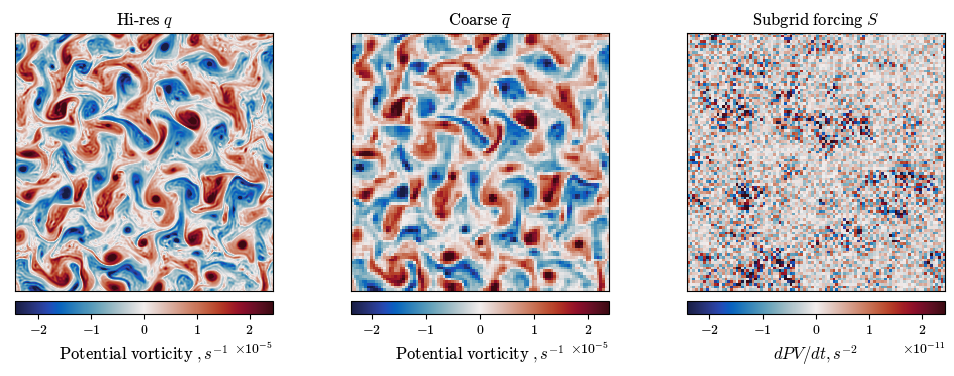

In [340]:
plt.figure(figsize=(12,4))
q = ds['256'].q.isel(time=-1,run=0)
plt.subplot(1,3,1)
imshow(q[0], cbar_label='Potential vorticity $, s^{-1}$', location='bottom')
plt.title('Hi-res $q$')
plt.subplot(1,3,2)
imshow(op.Operator1(q[0], 96), cbar_label='Potential vorticity $, s^{-1}$', location='bottom')
plt.title('Coarse $\overline{q}$')
sgs = op.PV_subgrid_forcing(q.values, 96, op.Operator1, {})
plt.subplot(1,3,3)
imshow(sgs[0][0], cbar_label='$dPV/dt, s^{-2}$', location='bottom')
plt.title('Subgrid forcing $S$')
plt.savefig(f'paper_figures_1/q_sgs.pdf')

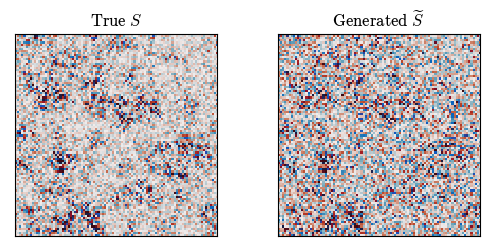

In [350]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
imshow(sgs[0][0], cbar=False)
plt.title('True $S$')
plt.subplot(1,2,2)
imshow(sgs[0][0]+np.random.randn(96,96)*0.7e-11, cbar=False)
plt.title(r'Generated $\widetilde{S}$')
plt.savefig(f'paper_figures_1/true_gen.pdf')

In [352]:
def L2(type='mean', model='OLSModel', operator='Operator1', resolution=64):
    folder = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'
    file = os.path.join(folder, operator+'-'+str(resolution),model,'offline_test.nc')
    if os.path.exists(file):
        ds = xr.open_dataset(file)
        if type != 'var_ratio':
            return float(ds['L2_'+type])
        else:
            return float(ds[type].mean())
    else:
        print('Wrong path', file)

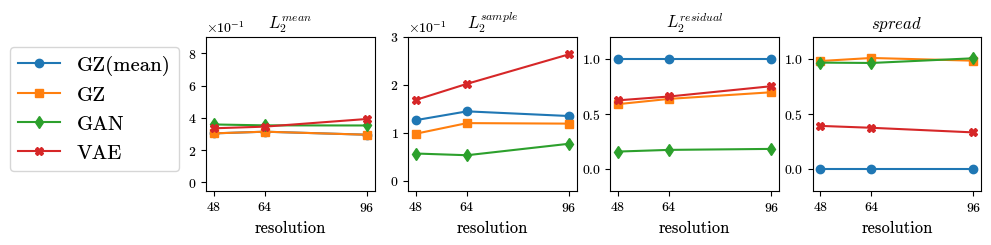

In [372]:
plt.rcParams.update({'font.size': 16})
markers = ['o', 's', 'd', 'X']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
lss = ['-', '-', '-', '-', '-', '-']
fig, axs = plt.subplots(1,4,figsize=(10,2))
axs = [axs]
plt.subplots_adjust(hspace=0.15, wspace=0.2)
for i, operator in enumerate(['Operator1']):
    for j, (model, label) in enumerate(zip(['OLSModel-0', 'MeanVarModel-0', 'CGANRegression-0', 'CVAERegression-None-0'], ['GZ(mean)', 'GZ', 'GAN', 'VAE'])):
        res = [48, 64, 96]
        L2_mean     = [L2('mean', model, operator, resolution) for resolution in res]
        L2_total    = [L2('total', model, operator, resolution) for resolution in res]
        L2_residual = [L2('residual', model, operator, resolution) for resolution in res]
        var_ratio = [L2('var_ratio', model, operator, resolution) for resolution in res]
        
        line = dict(marker=markers[j], color=colors[j], ls=lss[j])
        
        ax = axs[i][0]
        ax.plot(res, L2_mean, label=label, **line)
        ax.set_ylim([-0.05, 0.905])
        #ax.set_ylim([1e-2, 2])
        #ax.set_yticks([1e-2, 1e-1, 1e0])
        
        ax = axs[i][1]
        ax.plot(res, L2_total, label=label, **line)
        ax.set_ylim([-0.02, 0.3])
        #ax.set_ylim([1e-2, 2])
        #ax.set_yticks([1e-2, 1e-1, 1e0])
        #ax.set_yticklabels(['', '', ''])
        
        ax = axs[i][2]
        ax.plot(res, L2_residual, label=label, **line)
        ax.set_ylim([-0.2, 1.2])
        #ax.set_ylim([1e-2, 2])
        #ax.set_yticks([1e-2, 1e-1, 1e0])
        #ax.set_yticklabels(['', '', ''])
        
        ax = axs[i][3]
        ax.plot(res, var_ratio, label=label, **line)
        ax.set_ylim([-0.2, 1.2])
        
for j in range(4):
    axs[0][j].set_xlabel('resolution')
    axs[0][j].set_xticks([48, 64, 96])
    axs[0][j].set_xticks([48, 64, 96])
axs[0][0].set_title('$L_2^{mean}$')
axs[0][1].set_title('$L_2^{sample}$')
axs[0][2].set_title('$L_2^{residual}$')
axs[0][3].set_title('$spread$')

axs[0][0].legend(bbox_to_anchor=(-0.1,1), fontsize=15)

plt.savefig('paper_figures_1/metrics_GAN_VAE.pdf', bbox_inches='tight', pad_inches=0)

# Continue figures for paper

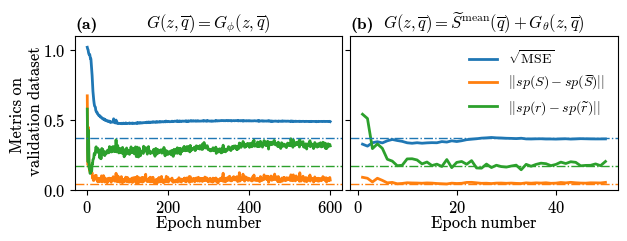

In [40]:
default_rcParams({
    'axes.titlelocation' : 'center', 
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.formatter.limits': (-2,3),})
stats_none = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression-None-long/model/stats.nc')
stats_correction = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/model/stats.nc')

fig, axs = plt.subplots(1,2, figsize=(7,2))
plt.subplots_adjust(wspace=0.03)

ax = axs[0]
stats_none.L2_mean_test.plot(ax=ax, lw=2, label='$L_2^{mean}$')
stats_none.L2_total_test.plot(ax=ax, lw=2, label='$L_2^{sample}$')
stats_none.L2_residual_test.plot(ax=ax, lw=2, label='$L_2^{residual}$')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Metrics on \n validation dataset')
ax.set_ylim([0, 1.1])
ax.set_title('$G(z,\overline{q})=G_{\phi}(z,\overline{q})$')

ax = axs[1]
stats_correction.L2_mean_test.plot(ax=ax, lw=2, label='$\sqrt{\mathrm{MSE}}$')
stats_correction.L2_total_test.plot(ax=ax, lw=2, label='$||sp(S) - sp(\widetilde{S})||$')
stats_correction.L2_residual_test.plot(ax=ax, lw=2, label='$||sp(r) - sp(\widetilde{r})||$')
ax.set_xlabel('Epoch number')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('$G(z, \overline{q}) = \widetilde{S}^{\mathrm{mean}}(\overline{q}) + G_{\\theta}(z, \overline{q})$')
ax.set_ylim([0, 1.1])
ax.legend(frameon=False)

for ax in axs:
    ax.axhline(y=stats_correction.L2_mean_test.sel(epoch=epoch), ls='-.', lw=1, color='#1f77b4')
    ax.axhline(y=stats_correction.L2_total_test.sel(epoch=epoch), ls='-.', lw=1, color='#ff7f0e')
    ax.axhline(y=0.17, ls='-.', lw=1, color='#2ca02c')
    
set_letters(x=0)


plt.savefig('paper_figures_1/training.pdf', bbox_inches='tight', pad_inches=0)